 This script would be using tensorflow to build a model that predicts an individual's response to progressive resistance exercise training (RE) measured as increase in muscle mass. The model would predict two variables; the response as a regression variable which ranks the response in 0-1 range, and the response as a categorical variable where the participant is ranked as mid-responder, high-responder, or no-responder

This model will be built based on 5 datasets; Alpha/Omega, COPD, Contratrain, Relief, Volume data. 

In [7]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
import pydot

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()


In [2]:
# Load the data containing the genecounts
genecounts = pd.read_csv("full_genecounts.csv")
# Initialise the scaler
scaler = StandardScaler()
# scale the genecounts 
genecounts_scaled = scaler.fit_transform(genecounts.iloc[:, 1:])
genecounts_scaled = pd.DataFrame(genecounts_scaled, columns = genecounts.columns[1:])

genecounts_scaled.insert(0, 'gene_id', genecounts['gene_id'])
genecounts_scaled = genecounts_scaled.set_index("gene_id")
genecounts_scaled = genecounts_scaled.T
genecounts_scaled = genecounts_scaled.reset_index().rename(columns = {"index": "seq_sample_id"})
genecounts_scaled

gene_id,seq_sample_id,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.15,ENSG00000001461.18,ENSG00000001497.18,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,-1.216719,0.092850,-0.737608,-0.205263,-0.982487,-0.407554,-0.514023,-0.460789,0.252554,...,-0.609845,-1.120897,-1.088956,-1.248659,0.454845,1.689885,-0.173323,-0.056207,-0.034913,-1.344482
1,s112,-0.963714,0.107694,-0.698514,0.086478,-0.772770,0.022830,-0.327234,-0.443922,0.022830,...,-0.401490,-1.525937,-1.080401,-1.239521,-0.051426,1.815580,-0.221154,0.425933,0.245597,-1.122833
2,s13,-1.232002,0.086604,-0.716921,-0.212143,-0.861144,-0.428476,-0.449080,-0.583001,0.107207,...,-0.706620,-1.551351,-1.479240,-1.427732,0.941637,1.425813,0.138112,0.498668,0.488366,-1.180494
3,s130,-1.289805,-0.001815,-0.493974,-0.075115,-1.132734,-0.473031,-0.420674,-0.829061,0.312329,...,-1.268863,-1.404992,-0.692932,-1.028019,0.825431,1.757391,0.239029,0.479872,0.406572,-1.206034
4,s136,-1.063594,0.126475,-0.627944,0.020218,-0.787328,-0.277299,-0.457934,-1.106096,0.158351,...,-0.797953,-1.382362,-1.191101,-0.957338,0.647129,1.794695,-0.256047,0.020218,-0.032910,-1.084845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,FP6w0R,-0.577890,0.549731,-0.405191,0.305921,-0.781065,-0.110588,-0.202016,0.001159,0.305921,...,-0.059794,-1.167097,-0.811541,-0.516937,2.957352,1.738303,-0.994398,-0.679477,-0.811541,-0.842017
285,FP7w0L,-0.926789,0.611394,-0.501764,0.115533,-0.926789,-0.198176,-0.410688,-0.208295,0.236968,...,0.429241,-0.724396,-1.382172,-0.461286,2.969267,1.765032,-1.159540,-0.592841,-0.896430,-1.159540
286,FP7w0R,-0.836191,0.601165,-0.674235,0.155787,-0.947535,-0.238979,-0.512280,-0.228857,0.236765,...,0.287376,-0.836191,-1.129735,-0.522402,2.959644,1.775344,-0.755213,-0.238979,-0.714724,-1.352424
287,FP9w0R,-0.900912,0.592340,-0.467062,-0.184555,-0.810106,-0.487241,-0.335898,-0.335898,0.390549,...,0.572161,-0.931181,-1.637449,-0.255182,2.923024,1.863622,-0.527599,-0.103838,-0.396435,-1.324673


In [3]:
# Load the full metadata
full_metadata = pd.read_csv("full_metadata.csv")
# round scaled percentage change to 2 decimal places 
full_metadata["scaled_pct_change"] = full_metadata["scaled_pct_change"].round(2)
# select onnly the variables needed for the model
metadata_full = full_metadata[["seq_sample_id", "age", "BMI", "scaled_pct_change", "category"]]
metadata_full

,seq_sample_id,age,BMI,scaled_pct_change,category
0,s104,46.0,29.0,0.42,Average_responder
1,s112,53.0,30.3,0.33,Average_responder
2,s13,46.0,25.3,0.92,High_responder
3,s130,58.0,29.9,0.26,Average_responder
4,s136,48.0,18.4,0.66,Average_responder
...,...,...,...,...,...
458,FP6w0R,21.8,20.5,0.09,No_responder
459,FP7w0L,21.2,28.2,0.73,Average_responder
460,FP7w0R,21.2,28.2,0.94,High_responder
461,FP9w0R,20.6,21.2,0.65,Average_responder


(array([19., 47., 93., 75., 77., 67., 40., 20., 14., 11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

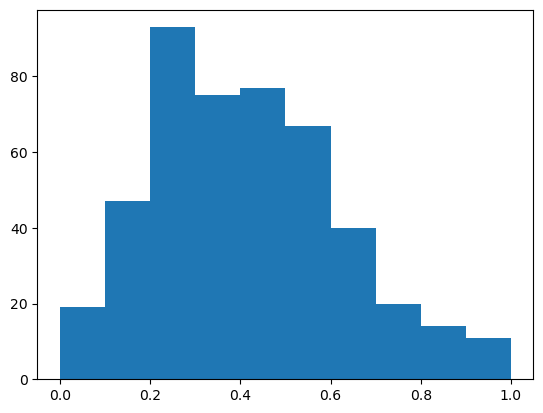

In [255]:
plt.hist(metadata_full["scaled_pct_change"])

(array([112.,  32.,  26.,  36.,  64.,  44.,  36.,  69.,  30.,  14.]),
 array([19. , 25.7, 32.4, 39.1, 45.8, 52.5, 59.2, 65.9, 72.6, 79.3, 86. ]),
 <BarContainer object of 10 artists>)

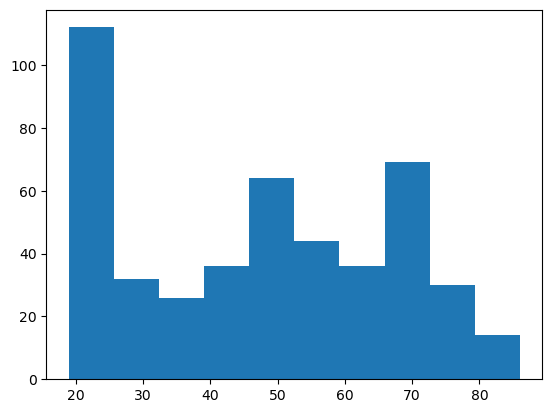

In [5]:
plt.hist(metadata_full["age"])

(array([ 35.,  77., 125.,  98.,  72.,  22.,  20.,  10.,   2.,   2.]),
 array([17.2, 20.1, 23. , 25.9, 28.8, 31.7, 34.6, 37.5, 40.4, 43.3, 46.2]),
 <BarContainer object of 10 artists>)

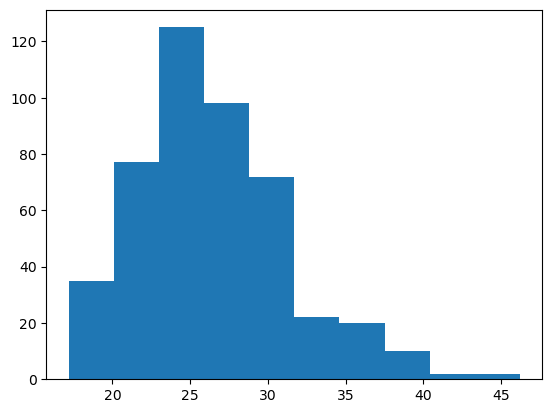

In [6]:
plt.hist(metadata_full["BMI"])

In [4]:
# join the gene expression data and the metadata

df = metadata_full.merge(genecounts_scaled, on = "seq_sample_id")
df = df.round(2)
df

,seq_sample_id,age,BMI,scaled_pct_change,category,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,46.0,29.0,0.42,Average_responder,-1.22,0.09,-0.74,-0.21,-0.98,...,-0.61,-1.12,-1.09,-1.25,0.45,1.69,-0.17,-0.06,-0.03,-1.34
1,s112,53.0,30.3,0.33,Average_responder,-0.96,0.11,-0.70,0.09,-0.77,...,-0.40,-1.53,-1.08,-1.24,-0.05,1.82,-0.22,0.43,0.25,-1.12
2,s13,46.0,25.3,0.92,High_responder,-1.23,0.09,-0.72,-0.21,-0.86,...,-0.71,-1.55,-1.48,-1.43,0.94,1.43,0.14,0.50,0.49,-1.18
3,s130,58.0,29.9,0.26,Average_responder,-1.29,-0.00,-0.49,-0.08,-1.13,...,-1.27,-1.40,-0.69,-1.03,0.83,1.76,0.24,0.48,0.41,-1.21
4,s136,48.0,18.4,0.66,Average_responder,-1.06,0.13,-0.63,0.02,-0.79,...,-0.80,-1.38,-1.19,-0.96,0.65,1.79,-0.26,0.02,-0.03,-1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,FP6w0R,21.8,20.5,0.09,No_responder,-0.58,0.55,-0.41,0.31,-0.78,...,-0.06,-1.17,-0.81,-0.52,2.96,1.74,-0.99,-0.68,-0.81,-0.84
459,FP7w0L,21.2,28.2,0.73,Average_responder,-0.93,0.61,-0.50,0.12,-0.93,...,0.43,-0.72,-1.38,-0.46,2.97,1.77,-1.16,-0.59,-0.90,-1.16
460,FP7w0R,21.2,28.2,0.94,High_responder,-0.84,0.60,-0.67,0.16,-0.95,...,0.29,-0.84,-1.13,-0.52,2.96,1.78,-0.76,-0.24,-0.71,-1.35
461,FP9w0R,20.6,21.2,0.65,Average_responder,-0.90,0.59,-0.47,-0.18,-0.81,...,0.57,-0.93,-1.64,-0.26,2.92,1.86,-0.53,-0.10,-0.40,-1.32


In [257]:
#X = df.drop(["seq_sample_id"], axis = 1)
#X

In [258]:
# Create the test and train data
# X = df.drop(["seq_sample_id"], axis = 1)
#X_train, X_test = train_test_split(X, test_size = 0.2, random_state=123)

# From the train data create the validation dataset
#X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 123)


# Print columns to verify
#print("Columns in X_train:", X_train.columns)
#print("Columns in X_test:", X_test.columns)
#print("Columns in X_val:", X_val.columns)


In [259]:
# Create the test and train data
X = df.drop(["seq_sample_id", "scaled_pct_change", "category"], axis = 1)
X_train, X_test = train_test_split(X, test_size = 0.2, random_state=123)

# From the train data create the validation dataset
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 123)

# use a function to get the two dependent variables
# would take as input the scaled pct change and catgorey
#def dep_variables(y):
#    pct_change = y.pop('scaled_pct_change')
#   pct_change = np.array(pct_change)
#    category = y.pop("category")
#    category_mapping = {'No_responder': 0, 'Average_responder': 1, 'High_responder': 2}
#    category = category.map(category_mapping)
#    category = np.array(category)
#    return pct_change, category

# get the dependent variables test, train and validation set
#y_train = to_categorical(dep_variables(X_train), num_classes= 3)
#y_test = to_categorical(dep_variables(X_test), num_classes = 3)
#y_val = to_categorical(dep_variables(X_val), num_classes = 3)

In [260]:
y_categorical = df["category"]
category_mapping = {'No_responder': 0, 'Average_responder': 1, 'High_responder': 2}
y_categorical = y_categorical.map(category_mapping)
y_categorical = np.array(y_categorical)
# split into train and test
y_cat_train, y_cat_test = train_test_split(y_categorical, test_size = 0.2, random_state=123)

# From the train data create the validation dataset
y_cat_train, y_cat_val = train_test_split(y_cat_train, test_size = 0.2, random_state = 123)

In [261]:
y_num = df["scaled_pct_change"]
y_num = np.array(y_num)
y_num_train, y_num_test = train_test_split(y_num, test_size = 0.2, random_state=123)

# From the train data create the validation dataset
y_num_train, y_num_val = train_test_split(y_num_train, test_size = 0.2, random_state = 123)

# The Model
Using https://github.com/peremartra/TensorFlow_Advanced/blob/main/guide-multiple-outputs-with-keras-functional-api.ipynb as guide

In [262]:
#Start with the input layer, where we must indicate the shape of the Data passed to the model. 
inputs = tf.keras.layers.Input(shape=(10928,))

#Add dense layers to the input layer. These layers are commom to both predicted variables. 
x = Dense(units=64, activation='relu')(inputs)
x = Dense(units=64, activation='relu')(x)
#x = Dense(units=32, activation='relu')(x)

#Add the output layer for the pct_rank using Sigmoid activation. 
y_rank_layer = Dense(units = 1, activation='sigmoid', kernel_regularizer = regularizers.l1(0.001), name='y_rank_layer')(x)

#Here we diversificate the model adding a new Dense layer to the Base layers (x)
category_layer=Dense(units=64, activation = "softmax", kernel_regularizer = regularizers.l1(0.001), name='category_layer')(x)

#The output layer for the category variable. It's added below the Dense Layer: quality_layer 
y_category_layer = Dense(units=1, activation = "sigmoid",  name='y_category_layer')(x)

#The Model is created indicating the inputs and outputs. 
model = Model(inputs=inputs, outputs=[y_category_layer, y_rank_layer])

#chose optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


#To compile the model we use two dictionaries, to indicate the loss functions and metrics 
#for each output layer. Note that the name of the layer must be the same than the 
#internal name of the layer. 
model.compile(optimizer=optimizer, 
              loss = {'y_rank_layer' : tf.keras.losses.Huber(delta = 0.5), 
                      'y_category_layer' : 'categorical_crossentropy'
                     },
              metrics = {'y_rank_layer' : 'mae', 
                         'y_category_layer': tf.keras.metrics.AUC(name='prc', curve='PR') # better for unbalanced datasets
                       }
             )

In [263]:
model.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape              ┃         Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)  │ (None, 10928)             │               0 │ -                         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_97 (Dense)             │ (None, 64)                │         699,456 │ input_layer_48[0][0]      │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_98 (Dense)             │ (None, 64)                │           4,160 │ dense_97[0][0]            │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ y_category_layer (Dense)     │ (None, 1)                 │              65 │ dense_98[0][0]            │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ y_rank_layer (Dense)         │ (None, 1)                 │              65 │ dense_98[0][0]            │
└──────────────────────────────┴───────────────────────────┴─────────────────┴───────────────────────────┘

 Total params: 703,746 (2.68 MB)

 Trainable params: 703,746 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

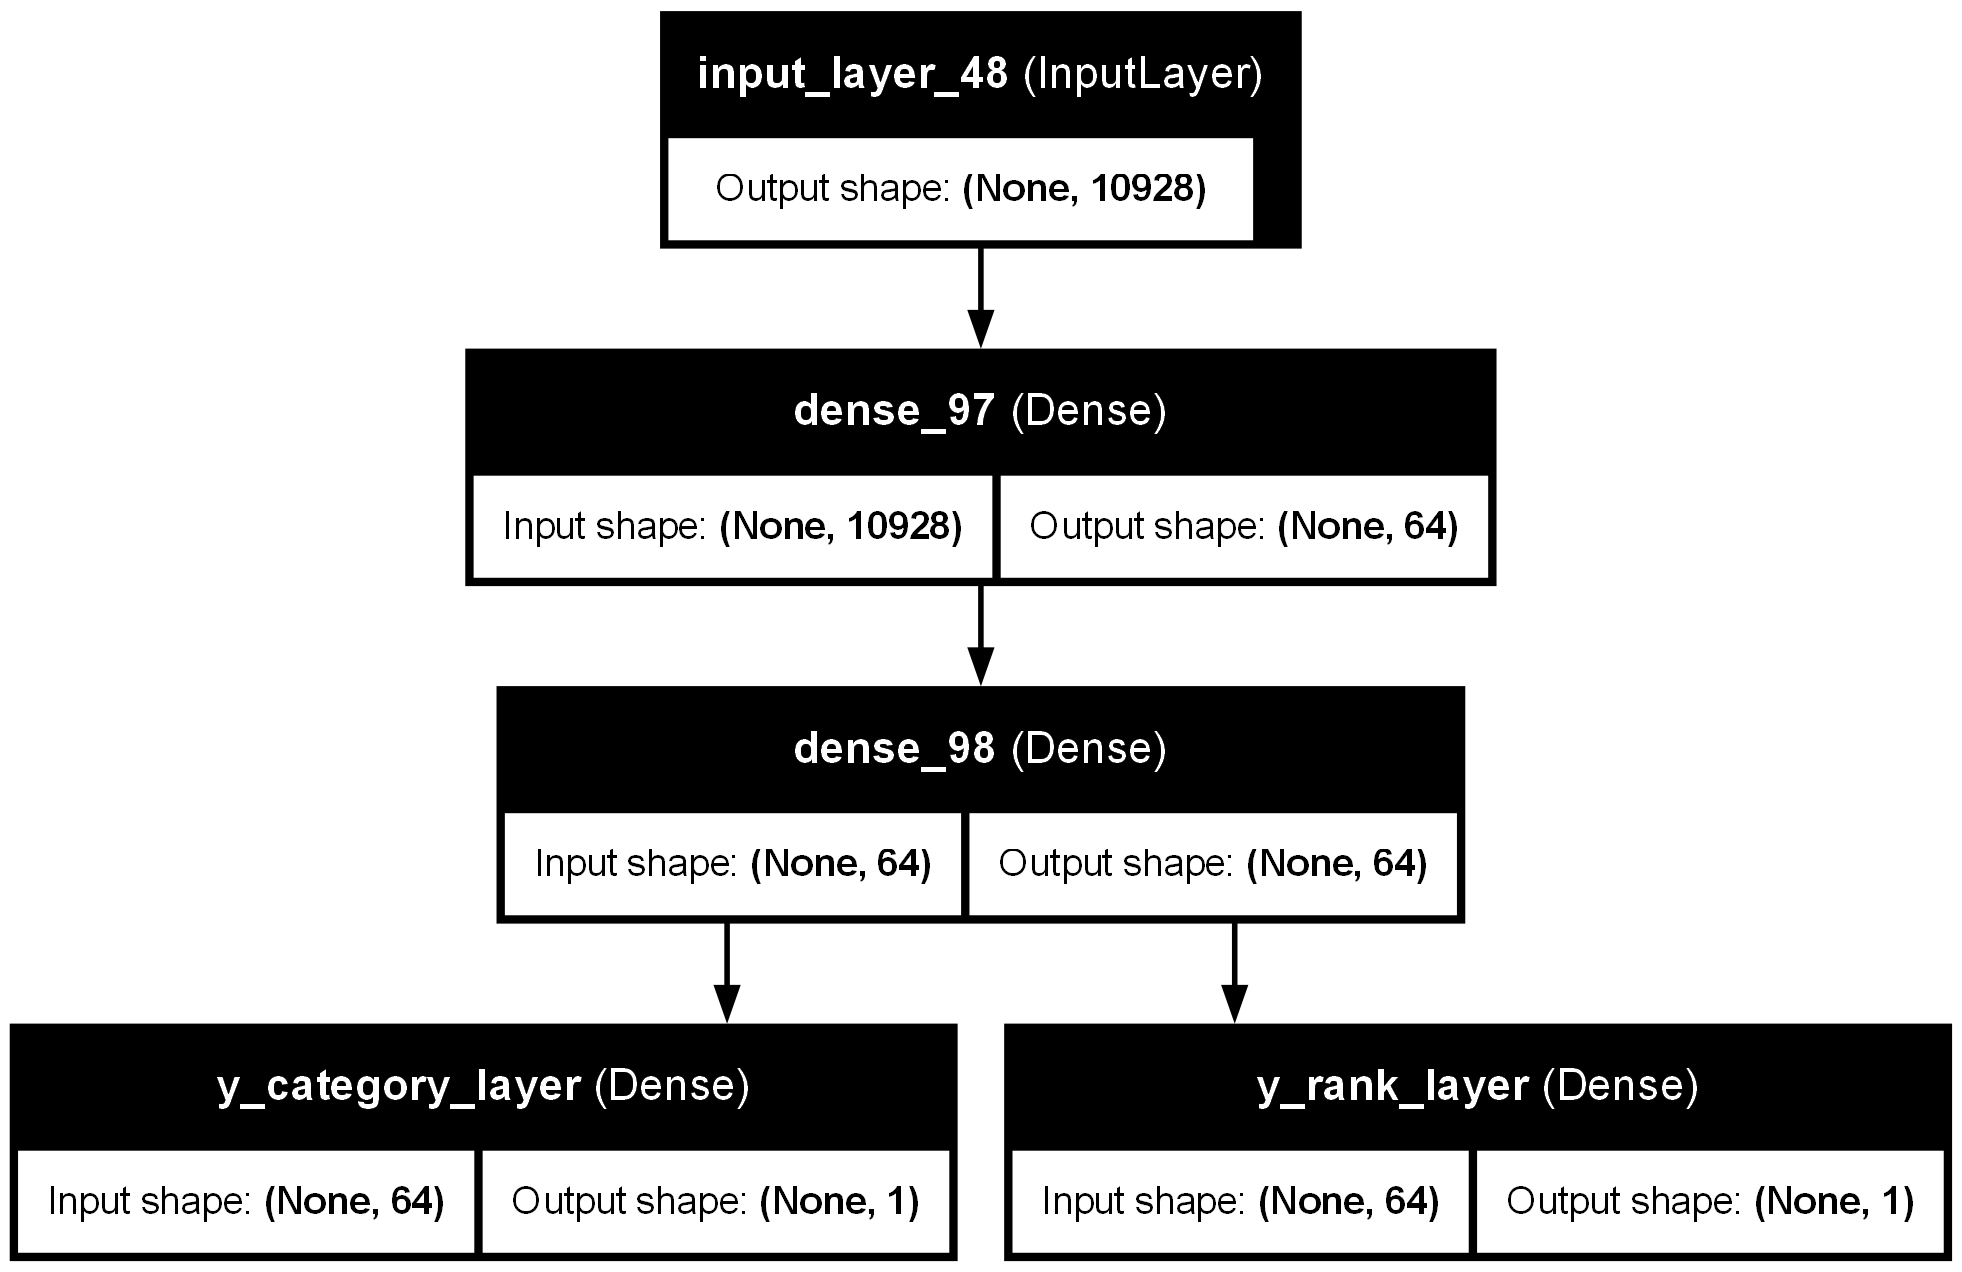

In [264]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [265]:
#history = model.fit(X_train, y_train, 
#                    epochs = 40, validation_data=(X_val, y_val))
# reduce learning rates
#red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train, 
                    {'y_category_layer': y_cat_train, 'y_rank_layer': y_num_train}, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_val, {'y_category_layer': y_cat_val, 'y_rank_layer': y_num_val}))


Epoch 1/20


C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0422 - y_category_layer_loss: 0.0000e+00 - y_category_layer_prc: 0.8440 - y_rank_layer_loss: 0.0327 - y_rank_layer_mae: 0.2051

C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0416 - y_category_layer_loss: 0.0000e+00 - y_category_layer_prc: 0.8450 - y_rank_layer_loss: 0.0320 - y_rank_layer_mae: 0.2029 - val_loss: 0.0334 - val_y_category_layer_loss: 0.0000e+00 - val_y_category_layer_prc: 0.7812 - val_y_rank_layer_loss: 0.0219 - val_y_rank_layer_mae: 0.1795
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0309 - y_category_layer_loss: 0.0000e+00 - y_category_layer_prc: 0.9003 - y_rank_layer_loss: 0.0215 - y_rank_layer_mae: 0.1696 - val_loss: 0.0300 - val_y_category_layer_loss: 0.0000e+00 - val_y_category_layer_prc: 0.8243 - val_y_rank_layer_loss: 0.0166 - val_y_rank_layer_mae: 0.1600
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0321 - y_category_layer_loss: 0.0000e+00 - y_category_layer_prc: 0.8843 - y_rank_layer_loss: 0.0228 - y_rank_layer_mae: 0.1726 - val_loss: 0.0293 - val_y_category_layer_loss: 0.0000e+00 - val_y_category_layer_prc: 0.8243 - val_y_rank_layer_loss: 0.0167 - val_y

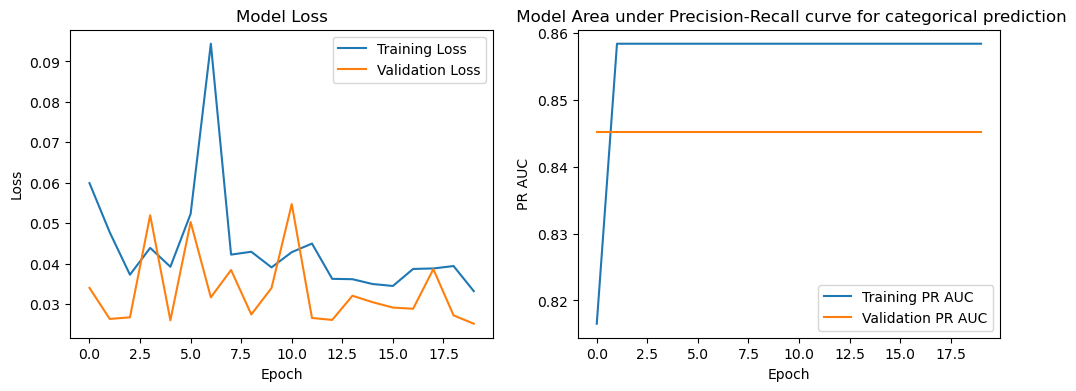

In [237]:

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.plot(history.history['y_category_layer_prc'], label='Training PR AUC ')
plt.plot(history.history['val_y_category_layer_prc'], label='Validation PR AUC')
plt.title(' Model Area under Precision-Recall curve for categorical prediction')
plt.xlabel('Epoch')
plt.ylabel('PR AUC')
plt.legend(loc='lower right')

plt.show()


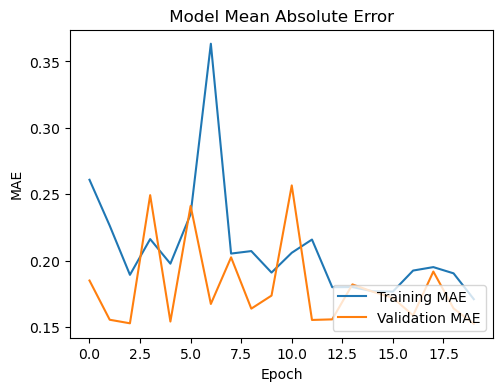

In [238]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['y_rank_layer_mae'], label='Training MAE ')
plt.plot(history.history['val_y_rank_layer_mae'], label='Validation MAE')
plt.title(' Model Mean Absolute Error ')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='lower right')


In [249]:
# Import explainer
from tf_explain.core.grad_cam import GradCAM

# Instantiation of the explainer
explainer = GradCAM()


In [248]:
pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ------------ --------------------------- 12.6/39.5 MB 65.5 MB/s eta 0:00:01
   ------------------------------------ --- 36.2/39.5 MB 91.9 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 83.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [250]:

# Call to explain() method
output = explainer.explain(history)

# Save output
#explainer.save(output, output_dir, output_name)
#explainer = shap.KernelExplainer(history,X_train)
#shap_values = explainer.shap_values(X_train.iloc[:,:])
#shap.summary_plot(shap_values,X_train,plot_type="bar", max_display=18)

TypeError: GradCAM.explain() missing 2 required positional arguments: 'model' and 'class_index'